

---
## <center ><h2><span style='color:green'>時間卷積網路 (Temporal Convolution Networks) 實作</span></h2></center>

---

# **1. 了解 Colab 的 container 及 目前 python 環境**

In [ ]:
#colab環境了解
!pip install idx2numpy
!pip list
!nvidia-smi

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=3b7759f549f65a06169a3804eb38f51ad6787ea33cdb97c9769c605f5cac1c37
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy
Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argcomplete                   2.0.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel    

In [ ]:
#個人 google drive 掛載
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. TCN 模型說明及前置作業**

本次針對2018年TCN首次披露的文獻內容進行實作，文獻連結如下：https://arxiv.org/pdf/1803.01271.pdf

裡面透過進行不同的任務來了解TCN在時序性資料的表現，並與其他模型進行效能比較。
本次實作我們將進行當中的兩個任務「Copying Memory Task」及「Sequential MNIST」，並為大家介紹TCN的運作。

在這之前，我們先進行前置作業及讓大家暸解TCN在pytorch內部的架構。

In [ ]:
import torch
torch.device('cuda')
from torch import nn
import argparse
from torch.nn.utils import weight_norm
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import idx2numpy
import numpy as np
import sys
import time
import warnings

In [ ]:
!git clone https://github.com/locuslab/TCN.git

Cloning into 'TCN'...
remote: Enumerating objects: 143, done.
remote: Total 143 (delta 0), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (143/143), 16.59 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (61/61), done.


**TCN 架構**


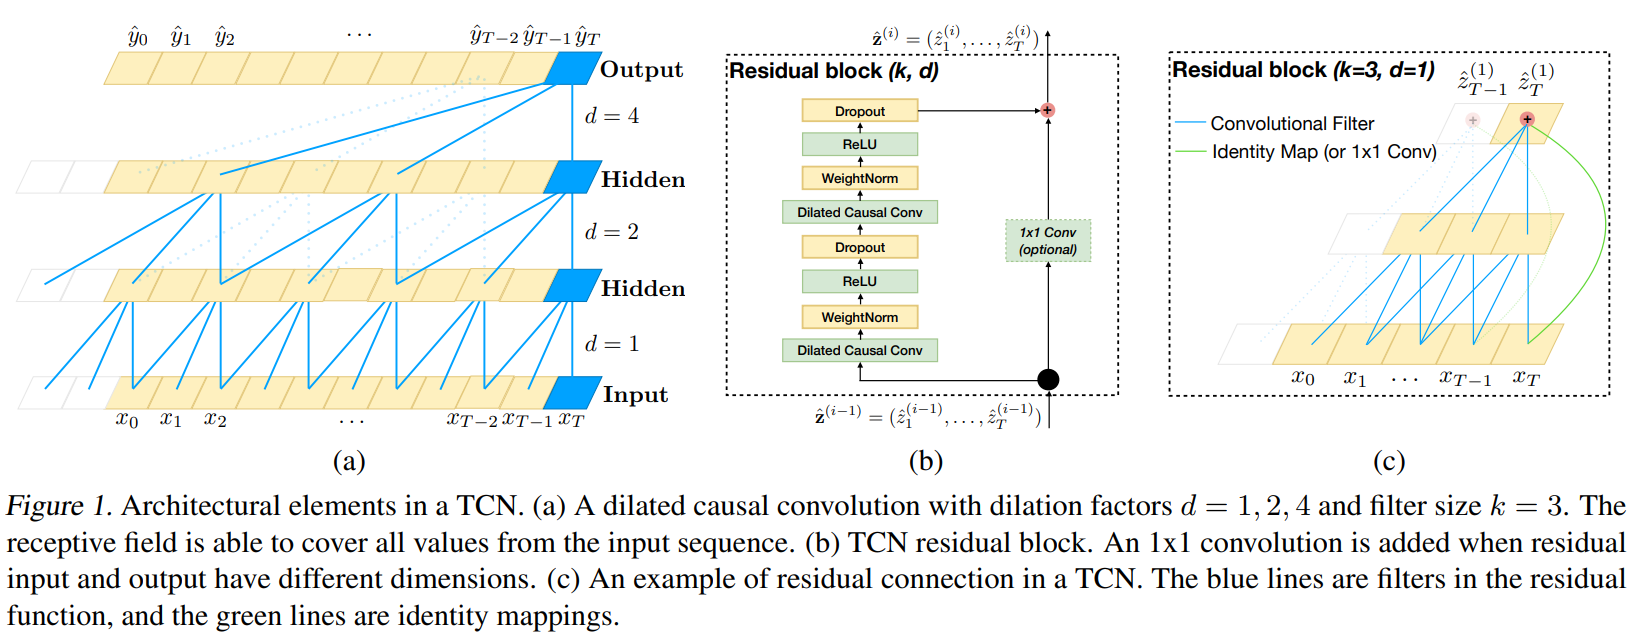


In [ ]:
# 用於修剪卷積後的資料尾端，裁剪多出來的padding讓其與輸入資料尺寸相同。
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

In [ ]:
# TCN的基本模組(相當於一個Residual block)，包含8個部分，兩個（卷積+修剪+relu+dropout）
# 裡面提到的downsample就是下採樣,即 1x1 Conv(optional)部分,如輸入與輸出之維度不同時進行。
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)  #殘差連結


In [ ]:
# TCN的主網絡 (串接多個 Residual Block)
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        # print('num_channels:',num_channels)
        for i in range(num_levels):
            # print('\nBlock no. (layer no.):',i)
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            # print('dilation_size:',dilation_size,'\nin_channels:',in_channels,'\nout_channels:',out_channels,'\nkernel_size:',kernel_size,'\npadding:',(kernel_size-1) * dilation_size)
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
            # print('layers:',layers)
        # print('\nlen(layers):',len(layers))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# **2. 數據預測應用 - Copying Memory Task**

Copying Memory Task 主要透過自行製造之數字資料，來測試模型在隔多個時間步長後記憶信息的能力(記多久)。

其方法如下：

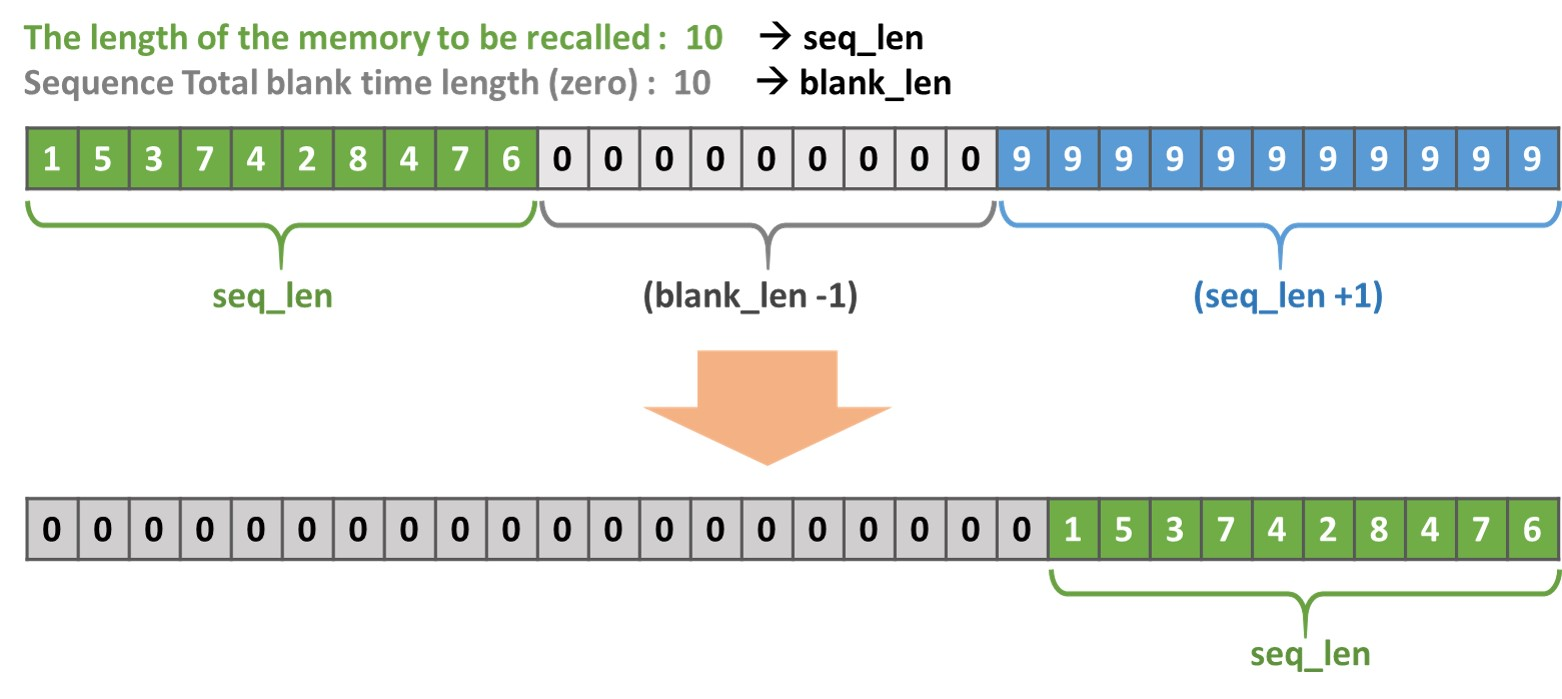 

In [ ]:
# 資料生成函式
def data_generator(T, mem_length, b_size):
    """
    Generate data for the copying memory task
    :param T: The total blank time length
    :param mem_length: The length of the memory to be recalled
    :param b_size: The batch size
    :return: Input and target data tensor
    """
    seq = torch.from_numpy(np.random.randint(1, 9, size=(b_size, mem_length))).float()
    zeros = torch.zeros((b_size, T))
    marker = 9 * torch.ones((b_size, mem_length + 1))
    placeholders = torch.zeros((b_size, mem_length))

    x = torch.cat((seq, zeros[:, :-1], marker), 1)
    y = torch.cat((placeholders, zeros, seq), 1).long()

    x, y = Variable(x), Variable(y)
    return x, y

In [ ]:
# TCN model 建立class
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1.transpose(1, 2))

In [ ]:
# 參數設定
args = {'seq_len':3 , #10
        'blank_len':10, #1000
                
        'seed':1111,
        'nhid':10,  #Dilated causal convolution中每層輸出的固定維度  
        'levels':8,  #Residual Block 數目
        'ksize':8,  #Kernel size
        'dropout':0.0,

        'optim':'RMSprop',
        'lr':5e-4,
        'log_interval':50,
        'epochs':15,
        'clip':1.0,   
        
        'cuda':'True',
        'batch_size':32,
           }

In [ ]:
#資料生成
torch.manual_seed(args['seed'])

seq_len = args['seq_len']    # The size to memorize
T = args['blank_len']


n_train = 10000
n_test = 10 #1000

print("Preparing data...")
train_x, train_y = data_generator(T, seq_len, n_train)
test_x, test_y = data_generator(T, seq_len, n_test)

print('train_x:  ',train_x.shape)
print('train_y:  ',train_y.shape)

print('test_x:  ',test_x.shape)
print('test_y:  ',test_y.shape)


Preparing data...
train_x:   torch.Size([10000, 1020])
train_y:   torch.Size([10000, 1020])
test_x:   torch.Size([10, 1020])
test_y:   torch.Size([10, 1020])


In [ ]:
#了解資料
print('The first sample in training data:')
print('\nX data:\n',train_x[0].numpy().astype('int32'))
print('\nY data (Target):\n',train_y[0].numpy().astype('int32'))

The first sample in training data:

X data:
 [2 5 8 0 0 0 0 0 0 0 0 0 9 9 9 9]

Y data (Target):
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 5 8]


The first 10 samples in training data:



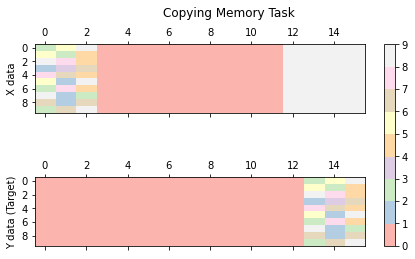

In [ ]:
#了解資料
print('The first 10 samples in training data:\n')
fig, (ax1, ax2) = plt.subplots(2,1)
fig.subplots_adjust(top=0.85,bottom=0.15,left=0.05,right=0.95,hspace=0.95)

cmap = plt.get_cmap('Pastel1')
t=ax1.matshow(train_x.cpu().numpy().astype('int32')[0:10],aspect='auto',cmap=cmap)
ax1.set_ylabel("X data")
p=ax2.matshow(train_y.cpu().numpy().astype('int32')[0:10],aspect='auto',cmap=cmap)
ax2.set_ylabel("Y data (Target)")

fig.suptitle('Copying Memory Task')
fig.colorbar(t,ax=(ax1,ax2),orientation="vertical",fraction=0.1)

plt.show()

In [ ]:
#建立 TCN model 
n_classes = 10  # Digits 0 - 9
channel_sizes = [args['nhid']] * args['levels']
kernel_size = args['ksize']
dropout = args['dropout']
model = TCN(1, n_classes, channel_sizes, kernel_size, dropout=dropout)

if args['cuda']:
    model.cuda()
    train_x = train_x.cuda()
    train_y = train_y.cuda()
    test_x = test_x.cuda()
    test_y = test_y.cuda()

In [ ]:
#模型訓練及驗證函式
def evaluate(log_dict=None):
    model.eval()
    with torch.no_grad():
        out = model(test_x.unsqueeze(1).contiguous())

        loss = criterion(out.view(-1, n_classes), test_y.view(-1))
        pred = out.view(-1, n_classes).data.max(1, keepdim=True)[1]

        correct = pred.eq(test_y.data.view_as(pred)).cpu().sum()
        counter = out.view(-1, n_classes).size(0)
        print('\nTest set: Average loss: {:.8f}  |  Accuracy: {:.4f}\n'.format(
            loss.item(), 100. * correct / counter))
        log_dict['test_loss_per_epoch'].append(loss.item())
        return loss.item()


def train(ep,log_dict=None):
    global batch_size, seq_len, iters, epochs
    model.train()
    total_loss = 0
    start_time = time.time()
    correct = 0
    counter = 0
    for batch_idx, batch in enumerate(range(0, n_train, batch_size)):
        start_ind = batch
        end_ind = start_ind + batch_size

        x = train_x[start_ind:end_ind]
        y = train_y[start_ind:end_ind]
        
        optimizer.zero_grad()
        out = model(x.unsqueeze(1).contiguous())
        loss = criterion(out.view(-1, n_classes), y.view(-1))
        pred = out.view(-1, n_classes).data.max(1, keepdim=True)[1]
        correct += pred.eq(y.data.view_as(pred)).cpu().sum()
        counter += out.view(-1, n_classes).size(0)
        if args['clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args['clip'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx > 0 and batch_idx % args['log_interval'] == 0:
            avg_loss = total_loss / args['log_interval']
            elapsed = time.time() - start_time
            print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f} | accuracy {:5.4f}'.format(
                ep, batch_idx, n_train // batch_size+1, args['lr'], elapsed * 1000 / args['log_interval'],
                avg_loss, 100. * correct / counter))
            start_time = time.time()
            total_loss = 0
            correct = 0
            counter = 0
        log_dict['train_loss_per_batch'].append(loss.item())


In [ ]:
#模型訓練參數匯入
batch_size = args['batch_size']
epochs = args['epochs']
lr = args['lr']

criterion = nn.CrossEntropyLoss()
optimizer = getattr(optim, args['optim'])(model.parameters(), lr=lr)

In [ ]:
#進行模型訓練
log_dict = {'train_loss_per_batch': [],'test_loss_per_epoch': []}
for ep in range(1, epochs + 1):
    train(ep,log_dict)
    evaluate(log_dict)

plt.figure()
plt.plot(log_dict['train_loss_per_batch'], label='train loss per batch')
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.legend()
plt.savefig('/content/train_loss_per_batch_CMT.jpg')

plt.figure()
plt.plot(log_dict['test_loss_per_epoch'], label='test loss per epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/test_loss_per_epoch_CMT.jpg')


| Epoch   1 |    50/  313 batches | lr 0.00050 | ms/batch 31.72 | loss 0.25207287 | accuracy 94.0591
| Epoch   1 |   100/  313 batches | lr 0.00050 | ms/batch 29.20 | loss 0.05598937 | accuracy 98.8692
| Epoch   1 |   150/  313 batches | lr 0.00050 | ms/batch 29.12 | loss 0.03958384 | accuracy 99.0156
| Epoch   1 |   200/  313 batches | lr 0.00050 | ms/batch 29.19 | loss 0.02936035 | accuracy 99.0449
| Epoch   1 |   250/  313 batches | lr 0.00050 | ms/batch 29.14 | loss 0.02468391 | accuracy 99.1072
| Epoch   1 |   300/  313 batches | lr 0.00050 | ms/batch 29.08 | loss 0.02287085 | accuracy 99.1245

Test set: Average loss: 0.02184392  |  Accuracy: 99.1667



KeyboardInterrupt: ignored

In [ ]:
#模型預測函式
def predict(model, X_test):
  with torch.no_grad():
    p = model(X_test)
  pred = p.view(-1, n_classes).data.max(1, keepdim=True)[1]
  prediction = torch.reshape(pred, (p.shape[0], p.shape[1])).cpu().numpy()
  return prediction

The first 10 samples in training data:



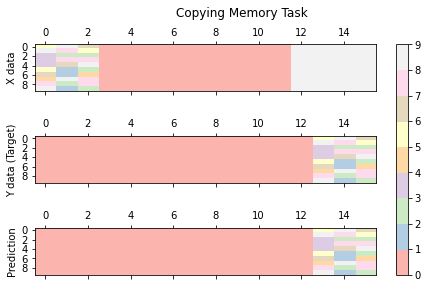

In [ ]:
#進行模型預測
prediction=predict(model,test_x.unsqueeze(1).contiguous())

print('Testing data:\n')
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.subplots_adjust(top=0.85,bottom=0.05,left=0.02,right=0.95,hspace=0.95)

cmap = plt.get_cmap('Pastel1')
t=ax1.matshow(test_x.cpu().numpy().astype('int32'),aspect='auto',cmap=cmap)
ax1.set_ylabel("X data")
p=ax2.matshow(test_y.cpu().numpy().astype('int32'),aspect='auto',cmap=cmap)
ax2.set_ylabel("Y data (Target)")
s=ax3.matshow(prediction.astype('int32'),aspect='auto',cmap=cmap)
ax3.set_ylabel("Prediction")

fig.suptitle('Copying Memory Task')

fig.colorbar(t,ax=(ax1,ax2,ax3),orientation="vertical",fraction=0.1)

plt.show()

# **3. 分類功能應用 - Sequential MNIST & Permuted Sequential MNIST**
「Sequential MNIST」任務經常用於測試 recurrent networks 保留過去信息的能力(記多少)。
\
\
在此任務中，每個數字圖像 (28 × 28) 都轉化為 784 × 1 的序列輸入TCN模型，並由模型進行分類數字(0-9)。 
\
\
另外，本次實作中除了「Sequential MNIST」，我們亦讓大家實作更具挑戰性的「Permuted Sequential MNIST」。「Permuted Sequential MNIST」中每個 784 × 1 序列以固定形式進行隨機排列，增加任務之難度。 
\
\
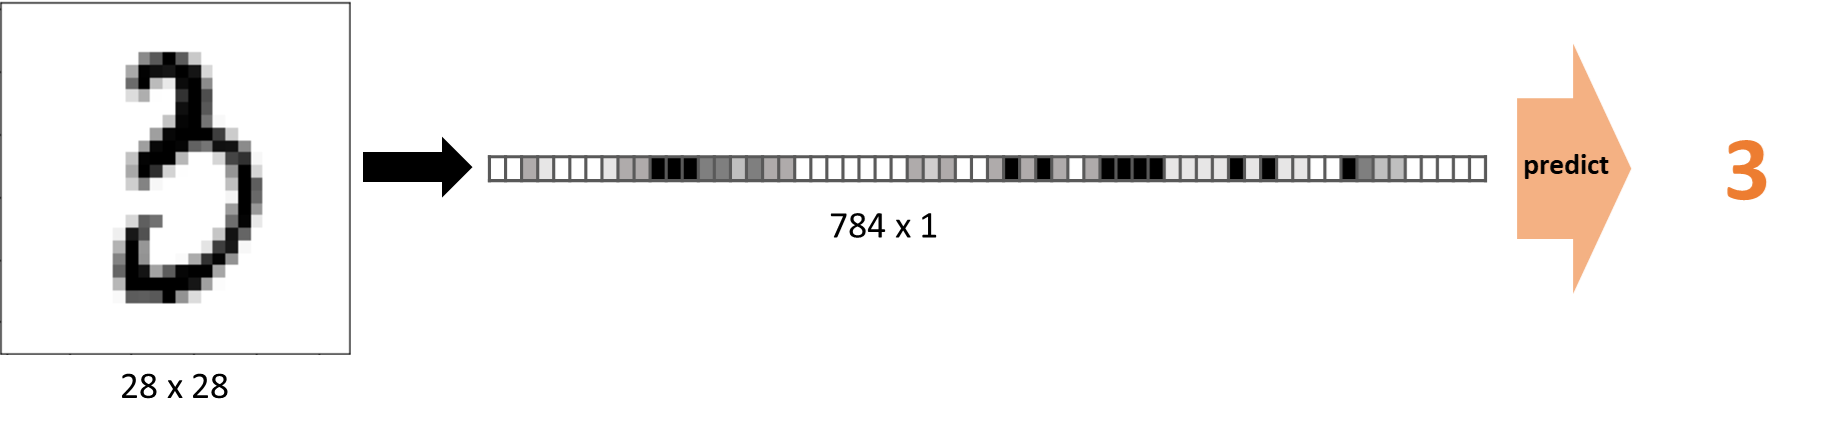

In [ ]:
#資料生成函式(MINST資料匯入及圖像轉化)
#transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
#Converts a PIL Image (H x W x C) to a Tensor of shape (C x H x W) and does normalization.

def data_generator(root, batch_size):
    train_set = datasets.MNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.MNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_set,test_set,train_loader, test_loader

In [ ]:
# TCN model 建立class
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return F.log_softmax(o, dim=1)

In [ ]:
# 參數設定
args = {'root':'/content/TCN/TCN/mnist_pixel/data/mnist', #請加入路徑
        
        'seed':1111,
        'nhid':25,
        'levels':8,
        'ksize':7, 
        'dropout':0.05,

        'optim':'Adam',
        'lr':2e-4,
        'log_interval':100,
        'epochs':3, #20
        'clip':-1,# -1 means no clip

        'cuda':'True',
        'batch_size':64,

        'permute':'False' 
           }

Shape of image array:  (28, 28)




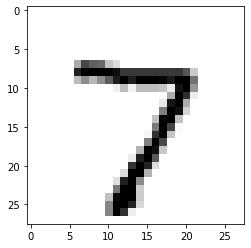

In [ ]:
#了解資料
imagefile = '/content/TCN/TCN/mnist_pixel/data/mnist/raw/t10k-images-idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)
print('Shape of image array: ',imagearray[0].shape)
print('\n')
plt.imshow(imagearray[0], cmap=plt.cm.binary)


In [ ]:
# 訓練集及測試集分配
torch.manual_seed(args['seed'])
root = args['root']
batch_size = args['batch_size']
train_set,test_set,train_loader, test_loader = data_generator(root, batch_size)

print('====================== Training Set ======================\n',train_set)
print('\n\n====================== Testing Set ======================\n',test_set)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/TCN/TCN/mnist_pixel/data/mnist/MNIST/raw

====================== Training Set ======================
 Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/TCN/TCN/mnist_pixel/data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


====================== Testing Set ======================
 Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/TCN/TCN/mnist_pixel/data/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [ ]:
#建立 TCN model
input_channels = 1
seq_length = int(784 / input_channels)
n_classes = 10
channel_sizes = [args['nhid']] * args['levels']
kernel_size = args['ksize']


model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=args['dropout'])


In [ ]:
# 如進行難度更高之「Permuted Sequential MNIST」時才使用。即參數輸入為 'permute':'True'。
permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
print(permute.shape)

if args['cuda']:
    model.cuda()
    permute = permute.cuda()

torch.Size([784])


In [ ]:
#說明進行難度更高之「Permuted Sequential MNIST」時之資料處理。
permute_example = np.random.permutation(5)
original_data = np.random.randint(10,size=(3,1,5))

print('Permutation order:\n',permute_example)
print('\n\nOriginal data:\n',original_data)
print('\n\nData after permuted:\n',original_data[:,:,permute_example])


Permutation order:
 [2 4 0 1 3]


Original data:
 [[[8 3 4 4 0]]

 [[7 8 7 0 0]]

 [[9 2 0 0 5]]]


Data after permuted:
 [[[4 0 8 3 4]]

 [[7 0 7 8 0]]

 [[0 5 9 2 0]]]


In [ ]:
# 說明訓練中之圖像轉化
for batch_idx, (data, target) in enumerate(train_loader):
  if args['cuda']: 
    data, target = data.cuda(), target.cuda()
  data = data.view(-1, input_channels, seq_length)

  print('Data shape per batch:')
  print(data.shape) # (batch size, 1, 784)

  print('\n\nData transformed from one image(sample):')
  print(data[0])
  break



Data shape per batch:
torch.Size([64, 1, 784])


Data transformed from one image(sample):
tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -

In [ ]:
#模型訓練參數匯入
steps = 0    
epochs = args['epochs']
lr = args['lr']
optimizer = getattr(optim, args['optim'])(model.parameters(), lr=lr)

In [ ]:
#模型訓練、測試及預測函式
def train(ep, log_dict=None):
    global steps
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']: 
          data, target = data.cuda(), target.cuda()
        data = data.view(-1, input_channels, seq_length)
        
        if args['permute']:
            data = data[:, :, permute]

        # Create Variables for the inputs and targets
        data, target = Variable(data), Variable(target)
        # Clear the gradients from all Variables
        optimizer.zero_grad()

        # Forward pass, then backward pass, then update weights
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if args['clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args['clip'])
        optimizer.step()
        train_loss += loss
        steps += seq_length
        if batch_idx > 0 and batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                ep, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()/args['log_interval'], steps))
            train_loss = 0
        log_dict['train_loss_per_batch'].append(loss.item())

def test(log_dict=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if args['cuda']:
                data, target = data.cuda(), target.cuda()
            data = data.view(-1, input_channels, seq_length)
            if args['permute']:
                data = data[:, :, permute]
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        log_dict['test_loss_per_epoch'].append(test_loss)
        return test_loss



def predict(sample_id):
    count_id=0
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            id = sample_id-count_id
            if 0<= id <batch_size:
              # print('id:',id) 
              if args['cuda']:
                  data, target = data.cuda(), target.cuda()
              data = data.view(-1, input_channels, seq_length)
              if args['permute']:
                  data = data[:, :, permute]
              data, target = Variable(data, volatile=False), Variable(target)
              output = model(data)
              prediction = output.data.max(1, keepdim=True)[1]
              print('prediction:',prediction[id].cpu().numpy()[0])
            count_id+=batch_size

In [ ]:
#進行模型訓練

warnings.filterwarnings("ignore")
log_dict = {'train_loss_per_batch': [],'test_loss_per_epoch': []}
for epoch in range(1, epochs+1):
    train(epoch, log_dict)
    test(log_dict)
    if epoch % 10 == 0:
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
  

plt.figure()
plt.plot(log_dict['train_loss_per_batch'], label='train loss per batch')
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.legend()
plt.savefig('/content/train_loss_per_batch_MNIST.jpg')

plt.figure()
plt.plot(log_dict['test_loss_per_epoch'], label='test loss per epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/test_loss_per_epoch_MNIST.jpg')


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.239463	Steps: 2285360
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.260507	Steps: 2363760
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.257034	Steps: 2442160
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.228940	Steps: 2520560
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.255991	Steps: 2598960
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.239617	Steps: 2677360
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.238180	Steps: 2755760
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.255770	Steps: 2834160
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.211281	Steps: 2912560

Test set: Average loss: 0.1762, Accuracy: 9474/10000 (95%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.191843	Steps: 3020752
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.214959	Steps: 3099152
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.221307	Steps: 3177552
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.202806	Steps: 3255952
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.222931	Steps: 3334352
Train Epoch: 2 [38400/60000 (64

KeyboardInterrupt: ignored

prediction: 3


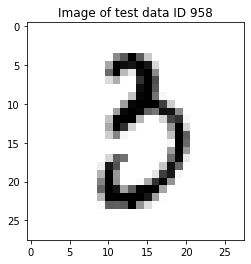

In [ ]:
#檢視預測結果

sample_id = 958 #可輸入 0 至 9999
imagefile = '/content/TCN/TCN/mnist_pixel/data/mnist/raw/t10k-images-idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)
plt.imshow(imagearray[sample_id], cmap=plt.cm.binary)
plt.title('Image of test data ID %s'%sample_id)
predict(sample_id)

# **4. 總結 及 資料補充**

本課程我們利用了 TCN 進行了「Copying Memory Task」及「Sequential MNIST & Permuted sequential MNIST (P-MNIST)」任務，並了解到 TCN 的運作及記憶能力。為了進一步讓大家了解本次任務上跟其他 recurrent network 的差異，下方引用文獻的實驗比較結果供大家參考。

\


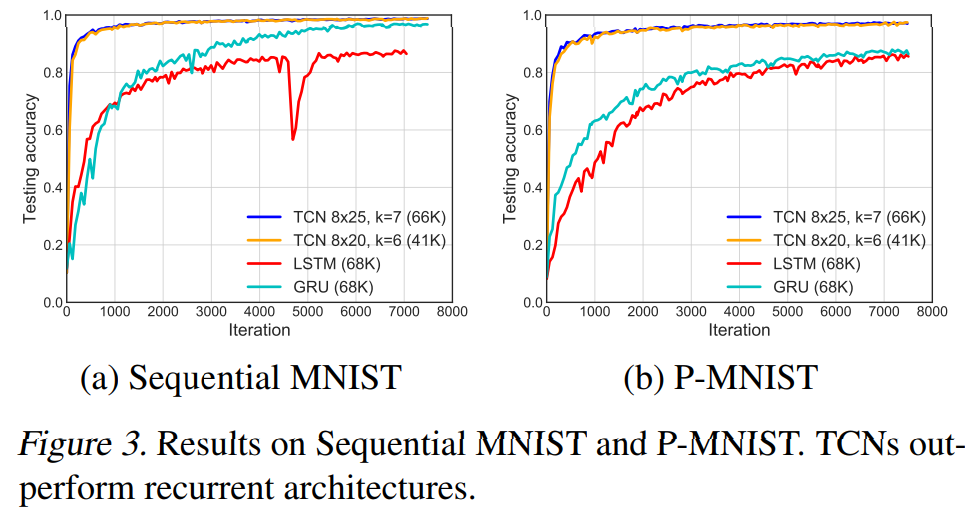


\

\


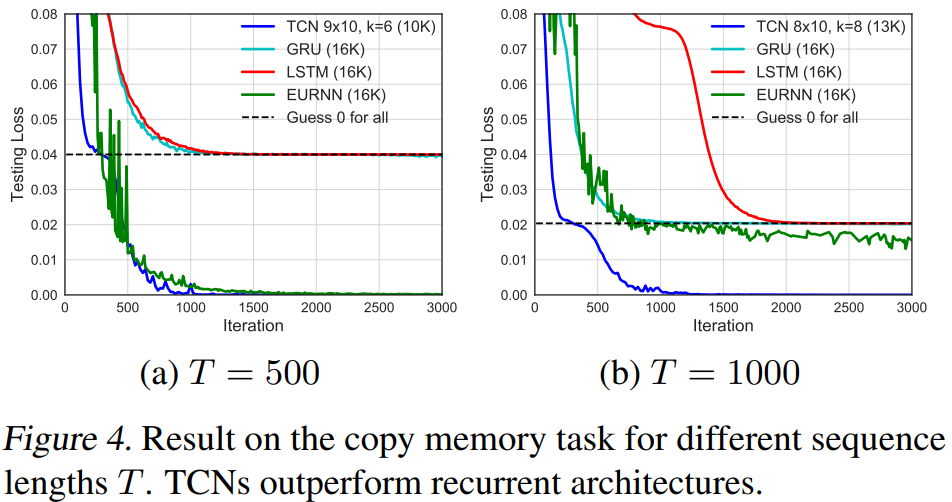
